<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [4]:
#| default_exp big_data_analytics.anova

In [ ]:
#|hide
import matplotlib.pyplot as plt

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2
plt.style.use('default')

## 代码与文档格式说明

本文档使用Jupyter Notebook编写，所以同时包括了实验文档和实验代码。

本次实验项目采用了 Quarto + nbdev 的系统来发布Jupyter Notebook, 因而我们的实验文档导出为pdf和html格式可以进行阅读，而我们的代码也导出为python模块形式，可以作为代码库被其他项目使用。

我们这样做的好处是，避免单独管理一堆 .py 文件，防止代码冗余和同步混乱，py文件和pdf文件都是从.ipynb文件导出的，可以保证实验文档和代码的一致性。

::: {.callout-important}
可以通过以下命令安装我们实验的代码：

```shell
pip install git+https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git
pip install matplotlib seaborn openpyxl scipy statsmodels
```
我们的代码导出为了python模块形式，通过以下命令导入：
```python
from thu_big_data_ml.big_data_analytics.anova import *
```
:::

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。
:::

## 1. Recall and write down the assumptions which one-way ANOVA are based on.

我们首先复习一下课件和上课的笔记：

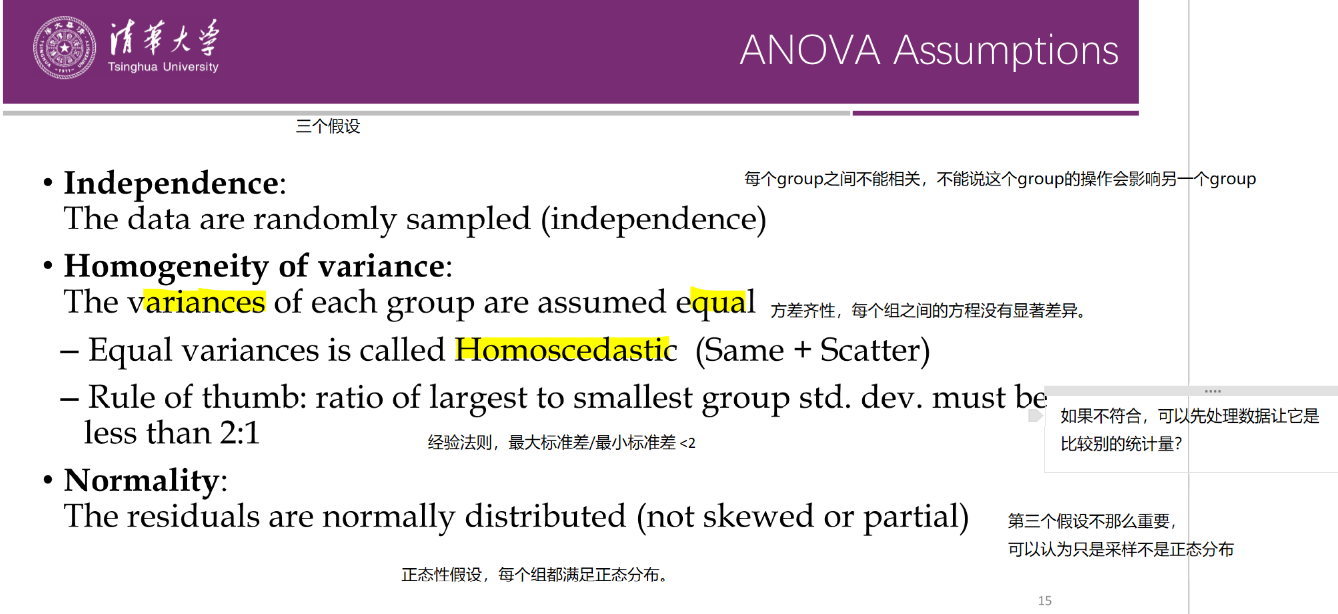

可知，one way ANOVA的**假设**（什么情况下可以进行该分析）是

1. 数据独立采样。

2. 不同组的方差一样。

3. 每一个组的数据都是服从正态分布。

课件后面还提到，如果不同组的数据的样本量一样大就更好了，叫做Balanced design

---

其中有些我们课上还没听懂的**疑难问题**，列出如下：

- 假设1的问题
  - 概率论中独立是什么意思来着？
  - ANOVA到底要求是谁和谁独立？
- 假设2的问题
  - 经验法则太经验了吧，不能通过假设检验来确定方差是否相等吗？
  - 老师说的方差不一样时还可以勉强用ANOVA，具体的数据处理方法是什么？
- 假设3的问题
  - 课上没讲“residuals”是啥？
  - 为什么老师说第三个假设不重要就算不满足也可以做ANOVA，有什么证据吗？
- 这三个假设具体在ANOVA后面的分析的哪一步被用到了？

## 2. State the null (H0) and the alternative (H1) hypotheses

> Focus on two columns: Category (Col[2]) and Average Age (Col[7]). 
>
> Taking feature Average Age as an example, we want to measure whether the average age varied significantly across the categories. **Clearly state** the null (H0) and the alternative (H1) hypotheses for this task

依题意，我们需要考察群类型和群员平均年龄的关系，首先假设检验这个关系是否存在。群类型是离散型随机变量，那么有关系就是说不同群类型下的年龄分布有所不同，使用ANOVA的时候，我们就是想说至少他们的均值是不同的。我们认为把实际上年龄分布相同但是被错误认为不同的概率要很小，所以把这个当做一类错误，即错误拒绝零假设的概率。因此，

- 零假设 H0: The mean Average Age (Col[7])s of all Category (Col[2] groups are equal. 按照不同类型分组的数据中，平均年龄这一列的每组的平均值是相等的。
  - groups也称 sub-populations
- 备择假设 H1: Not all mean Average Age (Col[7])s of all Category (Col[2] groups are equal. 至少存在一个群类型i和群类型j，这两个类型分组的数据的平均年龄是不相等的，从而所有群类型的平均年龄的平均值并非全都相等。
  - 注意这里并不会去说具体谁和谁不一样，需要post-hoc分析才知道。

## 3. Use my favorite statistics analysis software. 

> Use your favorite statistics analysis software, like Matlab, R, Excel, SPSS or …

这里我选择最喜欢的Python，灵活度最高，可编程性强，生态丰富，不过有人说里面的统计库有时候没有R的输出的专业。没关系啦。

注意到老师课堂上使用了Excel演示，我们有时间的话也稍微掌握一下。Excel的设计其实感觉很棒。



### 3.a Draw the empirical probability density function and Test normality
> Draw the empirical probability density function of Col[7], i.e. the empirical pdf of average age. Does the data in this dimension follow Gaussian distribution? Test normality of Col[7].

#### 文件读取
首先我们读取Excel文件到Python 的 pandas DataFrame

In [ ]:
from thu_big_data_ml.help import lib_repo_path

In [ ]:
data_excel_path = "data.xlsx"
data_excel_path = lib_repo_path/"notebooks/coding_projects/P1_ANOVA"/data_excel_path

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel(data_excel_path, sheet_name="data")
df.head()

,群名,群类别,群人数,消息数,稠密度,性别比,平均年龄,年龄差,地域集中度,手机比例,会话数,无回应比例,夜聊比例,图片比例
0,**手酒吧,1,63,315,0.051715,0.882353,26.681818,6.409413,0.222222,0.088889,23,0.434783,0.085714,0.069841
1,**秀嘉园,1,73,2,0.010274,0.579710,27.500000,9.042524,0.406780,0.000000,2,1.000000,1.000000,0.000000
2,**ˇ⒊無黒\噵丶⒈群,1,73,4,0.024163,0.750000,23.415385,4.699893,0.287879,0.500000,4,1.000000,0.000000,0.250000
3,**海网管工作联系基地,1,91,14,0.006105,0.901639,29.409091,2.854965,0.340426,0.142857,7,1.000000,0.250000,0.000000
4,tbsgame.net/bbs,1,133,2112,0.011107,0.961832,30.319672,4.669866,0.110236,0.167140,327,0.532110,0.104640,0.037879


In [8]:
df_category_info = pd.read_excel(data_excel_path, sheet_name="category_info")
df_category_info.head()

,编号,主题,数量
0,1,游戏,484
1,2,同学会,300
2,3,业主,196
3,4,投资理财,425
4,5,行业交流,635


因为是从0开始编号，所以题目说的第七列是

In [ ]:
df.columns, df.columns[7-1] 

(Index(['群名', '群类别', '群人数', '消息数', '稠密度', '性别比', '平均年龄', '年龄差', '地域集中度', '手机比例',
        '会话数', '无回应比例', '夜聊比例', '图片比例'],
       dtype='object'),
 '平均年龄')

#### 经验pdf绘制
现在我们可以绘制第七列（平均年龄）的经验概率密度函数图，这个图也叫做 直方图 histogram ，就是多个bin上面去经验地统计频数，从而来近似地描绘出数据分布的概率密度函数。


In [10]:
from matplotlib import pyplot as plt

In [ ]:
from matplotlib import font_manager

In [ ]:
# 设置matplotlib支持中文显示
# 参考网上资料，说要设为 SimHei
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体  
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
# 但是SimHei这个linux上不存在，好像是微软的字体，不开源。
# 参考另一篇博客解决这个问题 https://blog.csdn.net/MAO_TOU/article/details/93998905
font = font_manager.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams['font.sans-serif'] = [font.get_name()]

In [ ]:
import seaborn as sns

<Figure size 1000x600 with 0 Axes>

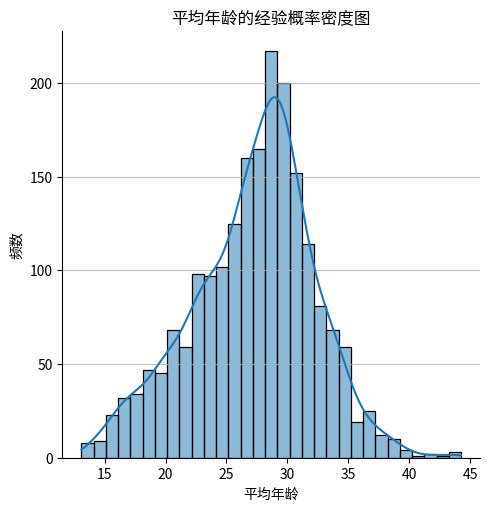

In [ ]:
plt.figure(figsize=(10, 6))
# plt.hist(df['平均年龄'], bins=10, color='skyblue', edgecolor='black')  # 使用列名绘制直方图
sns.displot(data=df, x=df.columns[7-1] , kde=True, kind="hist")
plt.title('平均年龄的经验概率密度图')
plt.xlabel('平均年龄')
plt.ylabel('频数')
plt.grid(axis='y', alpha=0.75)
plt.show()

上面的图不仅画了histogram，还画了kde曲线，kde是kernel density estimation的缩写，是一种非参数统计方法，用来估计概率密度函数。由于不是重点，这里不展开介绍，暂时只需要知道它和histogram类似都能反映分布，但是是连续曲线，所以可解释性较好。

#### 正态性检验
从图中来看，这一列的数据还是比较符合正态分布的。现在我们使用假设检验来验证这一点。
首先我们需要知道有哪些假设检验可以用来检验正态性，各自的优缺点有哪些？

我们找到两篇较为靠谱的论文 [Normality Tests](https://www.analystsoft.com/en/products/statplus/content/help/pdf/analysis_basic_statistics_normality_tests.pdf) [Power comparisons of Shapiro-Wilk, Kolmogorov-Smirnov,
Lilliefors and Anderson-Darling tests](https://www.nrc.gov/docs/ML1714/ML17143A100.pdf)，
里面对各个检验都有介绍，结合其他网络资料，我整理了以下的思维导图：

```{mermaid}
graph LR
    A[正态性检验] --> B[Shapiro-Wilk 夏皮罗-威尔克 检验]
    A --> C[Kolmogorov-Smirnov检验]
    A --> D[Anderson-Darling 安德森-达令检验]
    A --> E[D'Agostino-Pearson检验]
    A --> Z[Lilliefors检验]

    B --> F[零假设: 数据集来自于正态分布]
    B --> G[使用条件: 小样本, 具体来说n<50]
    B --> H[优点: 灵敏度高, 被认为是小样本情况下最强大的检验, 计算效率高]
    B --> I[缺点: 不适用于大样本, 过度敏感, 可能数据稍微偏离就误判不符合正态分布 ] 

    C --> J[零假设: 样本来自的总体与指定的理论分布无显著差异]
    C --> K[使用条件: 适用于连续分布, 大样本]
    C --> L[优点: 无需分布假设, 可以两列样本直接比较, 不需要指定分布参数]
    C --> M[缺点: 小样本上不够强大]

    D --> N[零假设: 样本来自的总体与指定的理论分布无显著差异]
    D --> O[使用条件: 适用于各种样本大小, 特别是当需要重视分布尾部差异时]
    D --> P[优点: 更重视分布尾部, 某些情况下比KS强大]
    D --> Q[缺点: 计算复杂, 每一个分布需要计算特定的临界值]

    E --> R[零假设: 数据集来自于正态分布]
    E --> S[使用条件: 大多数情况都可以]
    E --> T[优点: 基于偏度和峰度系数]
    E --> U[缺点: 结果容易受到异常值的影响]

    Z --> V[零假设: 数据集来自于正态分布]
    Z --> W[使用条件: 适用于小样本数据]
    Z --> X[优点: 虽然是检验正态性, 但是不用假设是来自于哪一个正态分布, 就是均值方差不用指定, 因为是KS检验的改进版]
    Z --> Y[缺点: 对于非独立同分布的数据不适用]

```

根据 https://www.lcgdbzz.org/custom/news/id/7951， 样本量大被认为是大于2000，
而根据https://blog.csdn.net/book_dw5189/article/details/133475648， 样本量<50或者 <200就认为小。
论文 https://www.amu.edu.my/wp-content/uploads/2024/01/V1_1_2023_Proceedings-of-Science-and-Management-2.pdf 中采用了 50 的说法。

我们的样本量是： 

In [13]:
len(df)

2040

不管是上面的哪个说法，都应该认为是大样本量，所以我们应当采用 KS AD 和 DP 检验，而不应该采用SW和L检验。

In [14]:
# 提取第七列数据
# data_column = df.iloc[:, 7-1]
data_column = df[df.columns[7-1]]

In [15]:
data_column

0       26.681818
1       27.500000
2       23.415385
3       29.409091
4       30.319672
          ...    
2035    28.330000
2036    27.928571
2037    25.723810
2038    27.085714
2039    27.223301
Name: 平均年龄, Length: 2040, dtype: float64

首先是KS检验，刚才思维导图我们有个地方说的模糊，其实KS检验有两个，一个是单样本，一个是双样本，单样本就是直接和理论分布比，双样本是两列样本去比。
这里我的疑问是，
- 两列样本的样本量可以不一样大吗？
    - 答，不需要，双样本测试的时候，不要求两列样本的样本量相同。
- 单样本KS检验是不是通过把理论分布采样出来得到第二个样本列，然后调用双样本KS检验去实现的？还是说另有方法？
    - 参考 https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    - KS检验的统计量是两个分布的最大差值，可以是经验分布或者理论分布。
    - 如果是经验分布和理论分布去算KS值，是否要采样理论分布呢？
    - 这个我暂时无法找到可信答案。

In [ ]:
from scipy import stats

In [ ]:
# 进行Kolmogorov-Smirnov检验
# ks_stat, ks_pvalue = stats.kstest(data_column, 'norm')
# 另一种写法
res = stats.ks_1samp(data_column, stats.norm.cdf, alternative='two-sided')
if res.pvalue < 0.05:
    print('Reject null hypothesis! Data is not normally distributed.')
res

Reject null hypothesis! Data is not normally distributed.


KstestResult(statistic=1.0, pvalue=0.0, statistic_location=13.097826087, statistic_sign=-1)

看来KS检验告诉我们这个数据不是高斯分布呀，看来我们人眼看图还是有一定的主观性。
继续进行下一个检验试试。

In [17]:
stats.anderson(data_column, dist='norm')

AndersonResult(statistic=9.382583309670736, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=27.222012543150147, scale=4.986570293065674)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

根据[文档](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)
> If the returned statistic is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected. 
这里统计量9.38比 1.09都要大，所以显著度为100%的情况下都可以拒绝原假设，认为数据不来自于选定的分布。

接下来是 D'Agostino-Pearson检验

In [ ]:
# 进行D'Agostino-Pearson检验
res = stats.normaltest(data_column)
if res.pvalue < 0.05:
    print('Reject null hypothesis! Data is not normally distributed.')
res

Reject null hypothesis! Data is not normally distributed.


NormaltestResult(statistic=24.479341544296894, pvalue=4.8348001102946654e-06)

根据[文档](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)
正态分布因为是 zero skewness and zero (“excess” or “Fisher”) kurtosis，所以统计量应该很低，
但是我们得到的很大，所以p值特别小，所以拒绝原假设，认为数据不服从正态分布。

综合上面的检验，一致地得出结论，也就是col[7]并不服从正态分布。如果三个测试是独立的，那我们的type 1 error就特别低了，是1-0.05^3。不过第一个KS检验直接笃定地告诉我们是0了。

这里我又产生了一个疑问，假如我们三个假设检验都是在检验一个事情，但是得出的结论又不一样，我应该相信谁呢？我应该怎么集成不同的结果来进行决策呢？这让我联想到课上老师说的ANOVA对应的post-hoc test，有type-1 error inflation 的问题，使用了 Bonferroni correction 进行了调整。
所以我们三个检验也应该搞个holm方法，从小到大排序p值，然后alpha值从小到大检验，防止我们错误地以为不是正态分布？

除了假设检验外，还可以用过图示法来检验分布的正态性，比如Q-Q plot和P-P plot，由于不是重点，这里就不做过多介绍了。

### 3.b Test the normality of each components and test the homogeneity of variances
> In Col[7], there are 5 components divided by category labels. We denote the data in Col[7] with category i (where i = 1,…,5) as Col[7|categoty=i]. Test the normality of each components and test the homogeneity of variances.

我们首先画图直观感受一下分开之后的分布图

Text(14.854888888888896, 0.5, '频数')

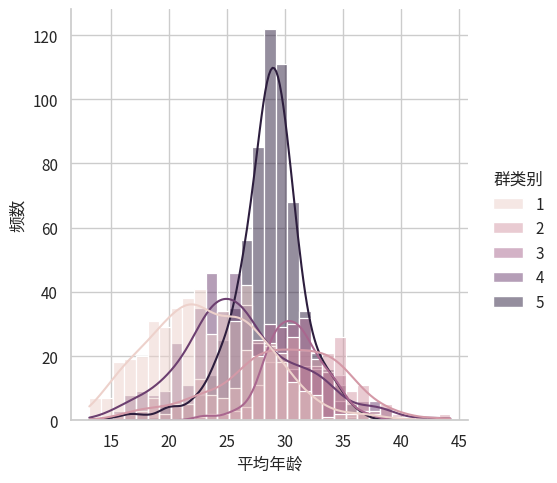

In [ ]:
sns.displot(data=df, x=df.columns[7-1], hue="群类别", kde=True, kind="hist")
plt.ylabel("频数")

从图中来看，数据看起来还是有点正态的，不过我们仍然需要假设检验。
而看起来方差并不是特别一致，特别是第5组图中能感觉方差明显小。

#### 正态性检验

我们使用 for 循环来对每个变量进行多种正态性检验方法。

In [ ]:
interesting_col = df.columns[7-1]
grouped_data = df.groupby('群类别')
# grouped_data
normality_results = {}
for name, group in grouped_data:
    normality_result = {}
    data_column = group[interesting_col]
    res = stats.ks_1samp(data_column, stats.norm.cdf, alternative='two-sided')
    normality_result['Kolmogorov-Smirnov'] = "Not Normal" if res.pvalue < 0.05 else "Normal"
    res = stats.anderson(data_column, dist='norm')
    critical_value = res.critical_values[2] # 0.05 level
    normality_result['Anderson-Darling'] = "Not Normal" if res.statistic > critical_value else "Normal"
    res = stats.normaltest(data_column)
    normality_result["D'Agostino-Pearson"] = "Not Normal" if res.pvalue < 0.05 else "Normal"
    normality_results[name] = normality_result
pd.DataFrame(normality_results)

,1,2,3,4,5
Kolmogorov-Smirnov,Not Normal,Not Normal,Not Normal,Not Normal,Not Normal
Anderson-Darling,Not Normal,Not Normal,Normal,Not Normal,Not Normal
D'Agostino-Pearson,Not Normal,Normal,Normal,Not Normal,Not Normal


由此可见，Col[7|categoty=2] 和 Col[7|categoty=3] 有可能是正态的，而另外三组都不太符合正态分布。

#### 方差齐性检验
我们首先使用 Rule of thumb 经验法则来看看数据是否满足方差齐性。

In [ ]:
std_devs = grouped_data[interesting_col].std()
ratio_largest_to_smallest = std_devs.max() / std_devs.min() 
variance_homogeneity = ratio_largest_to_smallest<= 2
std_devs, ratio_largest_to_smallest, variance_homogeneity

(群类别
 1    4.923757
 2    5.217371
 3    2.552901
 4    5.098256
 5    3.018979
 Name: 平均年龄, dtype: float64,
 2.0437025537615634,
 False)

哎呀看来差一点点，2.04刚好比2大一些，所以拇指法则认为我们做不了ANOVA啦。

下面我们再探索下假设检验来验证方差齐性，这样更严谨一些。

In [ ]:
group_values_list = [grouped_data[interesting_col].get_group(x).values for x in grouped_data.groups]
group_values_list[0][:5]

array([26.68181818, 27.5       , 23.41538462, 29.40909091, 30.31967213])

In [ ]:
from scipy import stats

In [ ]:
# 进行Bartlett的方差齐性检验
bartlett_result = stats.bartlett(*group_values_list)
if bartlett_result.pvalue < 0.05:
    print("Reject the null hypothesis of equal variances! ")
bartlett_result

Reject the null hypothesis of equal variances! 


BartlettResult(statistic=276.31560984738496, pvalue=1.387826766589022e-58)

可以明显看到pvalue特别低，所以很明显不同组的方差不一样，和拇指法则的结果是一致的。

### 3.c Do the one-way ANOVA test for Col[7] with categories in Col[2].
> Do the one-way ANOVA test for Col[7] with categories in Col[2]. Write down your conclusion, supporting statistics, and visualize your data which inspire the process.

我们首先可以画一个箱线图，直观感受一下数据的分布差异

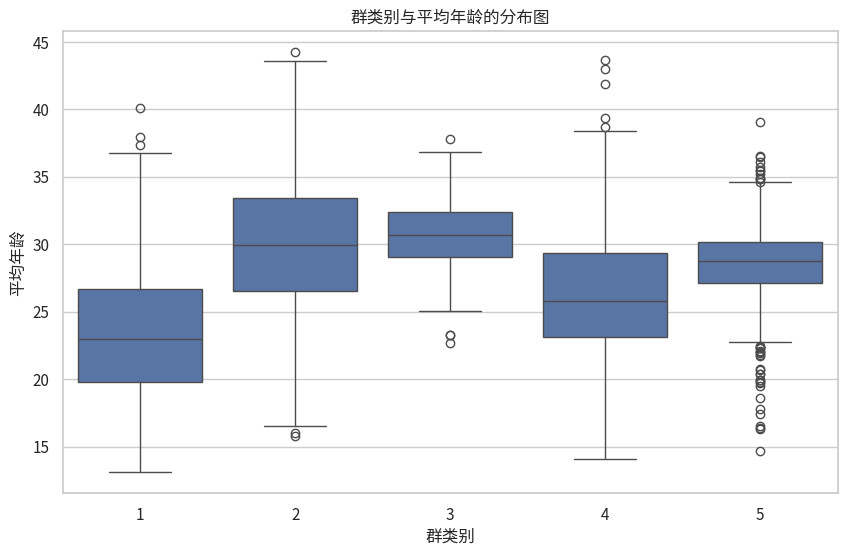

In [ ]:
# 绘制分组分布图
plt.figure(figsize=(10, 6))
sns.boxplot(x='群类别', y=df.columns[7-1], data=df)
plt.title('群类别与平均年龄的分布图')
plt.xlabel('群类别')
plt.ylabel('平均年龄')
plt.show()

可以感觉到他们的平均值还是有点差距的，现在我们尝试做ANOVA。
不过刚才3.b 我们发现ANOVA的假设并不成立，所以我们得分析结果未必准确。

In [ ]:
from scipy.stats import f_oneway # ANOVA 又称 F检验，所以scipy命名为f_oneway

In [ ]:
res = f_oneway(*group_values_list)
if res.pvalue < 0.05:
    print("Reject null hypothesis! There is a significant difference in the means between the groups.")
res

Reject null hypothesis! There is a significant difference in the means between the groups.


F_onewayResult(statistic=171.50703270711966, pvalue=1.0820916064752822e-126)

这里我们已经得到了结果，根据[文档](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)，scipy的statistic就是我们课上学习的F统计量，也就是 $F = \frac{between}{within}$，这就是我们的**Supporting statistic**。其中记得between和within不只是方差，还要除以自由度的。

我们的**Conclusion**就是不同群类别的平均年龄具有显著差异。

我们课上学习的时候，ANOVA能得到一个较为详细的表格，包括 SS, df, MS, 不只是上面scipy输出的F和p。所以我们决定使用更加专业的统计库 statsmodels 再来进行一次 ANOVA，参考[文档](https://www.statsmodels.org/stable/anova.html)。

In [ ]:
#| eval: false
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
#| eval: false
model = ols(f'{df.columns[1]} ~ C({df.columns[7-1]})', data=df).fit()

In [ ]:
#| eval: false
model.f_pvalue

0.2481580545669197

首先ols是个缩写，全称是 ordinary least squares (OLS), 与之对应的方法是 weighted least squares (WLS), generalized least squares (GLS)。

其中 C(x) 是 [R formula style 语法](https://segmentfault.com/q/1010000012066946)。
具体来说，
- ~：这是一个分隔符，用于区分因变量（响应变量）和自变量（解释变量或预测变量）。
- C(x)函数用于指定x变量应该被视为categorical variable。在R中，分类变量通常用于表示名义尺度或序数尺度的变量，比如性别、种族、国家等。
- 那么具体来说R语言是怎么处理C(x)的呢？在Python sklearn里面我们经常会用one hot编码，R也是使用one hot编码吗？
- 实际上，R语言单独有因子(Factor)类型，不是先处理为one hot再输入ols，而是直接输入ols让ols决定具体怎么处理。
- "Y ~ X1+X2" + 表示 X1 和 X2 都是自变量。
- 可以参考 http://www.sthda.com/english/articles/40-regression-analysis/163-regression-with-categorical-variables-dummy-coding-essentials-in-r/





In [ ]:
#| eval: false
anova_table = sm.stats.anova_lm(model, test='F', typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(平均年龄),4844.373039,1922.0,1.103449,0.248158
Residual,267.250000,117.0,NaN,NaN


为什么使用statsmodels库的时候我们用到了线性回归呢？
参考[这本书第九讲](https://bookdown.org/hetongqi0320/qht_R4psyBook/%E7%AC%AC%E5%85%AB%E8%AE%B2%E5%9B%9E%E5%BD%92%E6%A8%A1%E5%9E%8B%E4%B8%80.html#anova-linear-regression)的内容，我们了解到，ANOVA本质上检验线性回归模型的参数是否为零。这篇[科普文章](https://zhuanlan.zhihu.com/p/64553954?utm_id=0)也可以参考一下。

刚才调用的两个库其实都和我们课上学习的有点不一样，为了加深我们的理解，我们**自己实现一下**ANOVA。
根据课件上的顺序，我们逐一计算
- grand mean
- between-group variation
- within-group variation

In [ ]:
#| export
import numpy as np
import pandas as pd

In [ ]:
#| export
def anova_oneway(
    *groups: np.ndarray # 不同i的samples[i]表示不同的treatment下的实验数据。这里有个关键的地方，就是每一个group不要求有相同的长度，所以不是二维数据，而是一列不定长的np.array。
                 )->pd.DataFrame: # 返回ANOVA表格。包括我们课堂上学习的内容。
    if len(groups) < 2:
            raise TypeError('我们需要至少两个组才能进行ANOVA分析, 而'
                            f' 你给了我 {len(groups)} 个组.')
    means = [sum(group)/len(group) for group in groups]
    lengths_of_each_group = [len(group) for group in groups]
    
    # grand_mean = sum(means) / len(means) # 错误的公式
    # 正确公式1
    grand_mean = sum([mean*length for mean, length in zip(means, lengths_of_each_group)]) / sum(lengths_of_each_group)
    # 正确公式2
    flattened_samples = np.concatenate(groups)
    grand_mean_2 = flattened_samples.mean()
    assert np.isclose(grand_mean, grand_mean_2)

    # 平方和（Sum of Squares, SS）这个缩写课上其实没有讲，所以没听懂。
    # 计算组间平方和（Between SS）
    # between_ss = len(samples) * sum(mean**2 for mean in means)  # 错误的公式, 按照字面意义理解了 SS
    # 想算每一个group，如果把 grand mean 当做平均值， 把这个group的均值当做这个group所有人的值，那么这个group会有多大方差（没平均）。
    between_ss = sum([length * (mean - grand_mean)**2 for mean, length in zip(means, lengths_of_each_group)])
    
    # 计算组内平方和（Within SS）
    within_ss = sum(
        [
            (sum([(value-means[group_index])**2 for value in group]) # 每一个组自己求和
    ) for group_index, group in enumerate(groups) # 外层求和
        ]
    )

    # 计算总平方和（Total SS）
    # 但是我们实际上并不是算平方和啊，我们算的是和平均值差的平方和啊？这个取名。。。
    # ss_total = sum(sum(x**2 for x in sample) for sample in samples) # 错误的公式, 按照字面意义理解了 SS。
    # 正确公式1
    ss_total = sum(sum((x-grand_mean)**2 for x in group) for group in groups)
    
    # 正确公式2
    ss_total2 = between_ss + within_ss
    assert np.isclose(ss_total, ss_total2), f"{ss_total} vs {ss_total2}"
    
    # 课堂上其实没有讲，这里有一个重要的定理叫做 方差分解定理（law of total variance），
    # Var(X)=E[Var(X∣Y) ]+Var(E[X∣Y])
    

    
    # 计算自由度（df）
    df_between = len(groups) - 1
    df_within = sum([len(group) - 1 for group in groups]) # 注意这里是每一个 treatment 的自由度的和。
    
    # 计算均方（MS）
    ms_between = between_ss / df_between
    ms_within = within_ss / df_within
    
    # 计算F值
    f_value = ms_between / ms_within
    
    # 计算p值
    p_value_bigger_than_f = 1 - stats.f.cdf(f_value, dfn=df_between, dfd=df_within)
    p_value_excel = stats.f.pdf(f_value, dfn=df_between, dfd=df_within)
    # p_value = 1 - stats.f.cdf(f_value, dfn=df_within, dfd=df_between)
    
    # 创建ANOVA表格
    anova_table = {
        'Source': ['Between', 'Within', 'Total'],
        'Sum of Squares (SS)': [between_ss, within_ss, ss_total], # 拒绝缩写！我们要清晰地告诉用户这个是什么意思。
        'Degrees of Freedom (df)': [df_between, df_within, df_between + df_within], # 拒绝缩写
        'Mean Square (MS)': [ms_between, ms_within, None], # 拒绝缩写
        'F': [f_value, None, None],
        'p': [p_value_bigger_than_f, None, None],
        'p_excel': [p_value_excel, None, None]
    }
    return pd.DataFrame(anova_table)

,Source,Sum of Squares (SS),Degrees of Freedom (df),Mean Square (MS),F,p,p_excel
0,Between,12782.918190,4,3195.729547,171.507033,1.110223e-16,1.613847e-126
1,Within,37918.617834,2035,18.633227,NaN,NaN,NaN
2,Total,50701.536024,2039,NaN,NaN,NaN,NaN


In [ ]:
res = anova_oneway(*group_values_list)
res

其中我们F为什么叫做F呢？
- 其实是因为 F Value obeys Fisher Distribution， 这个分布是 Fisher大神提出的（ANOVA也是Fisher提出的），Fisher把自己的F命名进去。

那p为什么叫做p呢？
- p 是 probabilty的缩写，表示事件发生的概率，什么事情呢？
- 如果null hypothesis是正确的，数据出现这件事情的概率。
- 所以p也是如果拒绝 null hypothesis，我们会犯错误的概率，也就是 Type I Error。

我们再试一下excel表格的ANOVA，看看和我们刚才编写的代码结果一不一样。

首先默认来说Excel没有开启分析功能。需要 “文件”->“选项”->“加载项”，在“管理”下拉菜单中选择“Excel加载项”，然后勾选“分析工具库”和“分析工具库 - VBA”来完成加载。

第二，Excel的ANOVA对输入格式有要求，必须是分组之后矩阵的形式，我们原本的数据就是两列，所以不对，需要先把数据整理成分组之后的矩阵形式。
- 然而，在尝试了数据透视表、excel公式等方式之后，我放弃了，excel分个组太麻烦了。
- 我觉得直接python导出数据到excel，然后用excel的分析功能来做ANOVA。


In [ ]:
group_values_df = pd.DataFrame(group_values_list)
group_values_df.to_excel("group_values.xlsx")
group_values_df

,0,1,2,3,4,5,6,7,8,9,...,625,626,627,628,629,630,631,632,633,634
0,26.681818,27.500000,23.415385,29.409091,30.319672,26.112500,29.738095,26.313433,24.415094,23.933333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37.109375,27.147059,28.631579,20.212121,26.171717,17.106383,30.333333,38.266667,26.494118,31.022222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27.500000,30.083551,32.457746,35.086420,31.474576,28.626866,30.650206,34.169811,30.225000,33.113924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24.254545,26.245283,30.533333,26.333333,23.964286,27.645833,27.718750,33.693878,28.571429,20.219178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31.019355,28.986667,29.116279,29.401430,27.616216,32.521053,32.454545,26.257143,28.516129,31.014634,...,27.377049,27.112,26.623632,25.816667,25.668712,28.33,27.928571,25.72381,27.085714,27.223301


在弹出的“数据分析”对话框中，选择“方差分析：单一因子（ANOVA：Single Factor）”，然后点击“确定”。
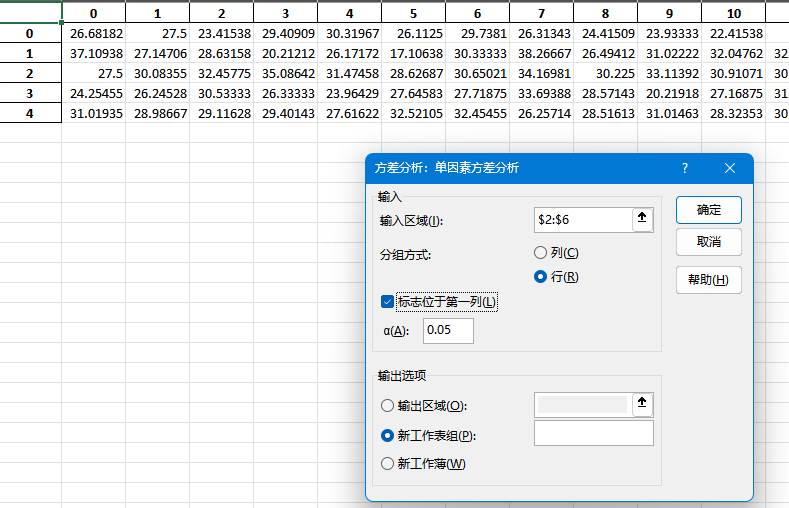

结果如下

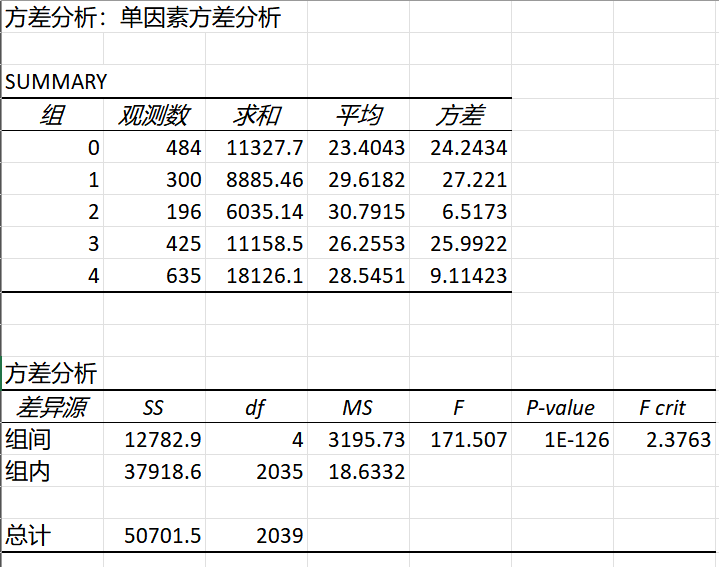

我们看到excel计算的结果和我们自己计算的结果一致，除了 p value不同。

我们的pvalue 是按照课件上的图来的，就是 X~F(df_between, df_within)下 P(X>f_value)，仔细检查还是没发现问题。

但是确实 excel计算的结果又和 scipy的一样，说明是我们错了而不是他们错了。

所以我们课件上的计算方法其实后来有改进版本，能得到更加准确的pvalue。

经过检查，原来excel和scipy采用的p value 是  P(X=f_value), 直接使用了密度函数那个位置的值。

根据[网上问答](https://www.quora.com/What-is-the-meaning-of-Pr-F-in-Anova-Is-it-a-P-value) 这两个方法算p value都是OK的。



另一个问题是，OLS得到的pvalue和excel、scipy以及我们的结论不一致，OLS似乎认为变化不显著！

## 4. Find another three columns and test whether they follow the ANOVA assumptions.
> Choose another 3 columns, draw the empirical pdf of each feature columns and test which column follows these assumptions in question 1? How about their corresponding log transformation?

首先我们需要连续型随机变量，我们看看那些是

In [ ]:
continuous_vars = df.select_dtypes(include=['float'])
continuous_vars.describe()

,稠密度,性别比,平均年龄,年龄差,地域集中度,手机比例,无回应比例,夜聊比例,图片比例
count,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
mean,0.075238,0.653186,27.222013,5.274628,0.552023,0.261570,0.705734,0.145622,0.032474
std,0.114423,0.191333,4.986570,2.407647,0.294685,0.277207,0.236187,0.186805,0.080868
min,0.000303,0.000000,13.097826,0.335623,0.076543,0.000000,0.000000,0.000000,0.000000
25%,0.010693,0.542373,24.035470,3.774116,0.250000,0.019967,0.523719,0.011480,0.000000
50%,0.024804,0.667256,27.880909,5.356491,0.576114,0.166667,0.718730,0.087869,0.006719
75%,0.076384,0.798379,30.436108,6.727624,0.836538,0.428571,0.921559,0.200000,0.030185
max,0.609764,1.000000,44.243902,13.841550,1.000000,1.000000,1.000000,1.000000,1.000000


注意 群人数	消息数 会话数 这几个变量是整数，但是不是类别型随机变量，大小是有意义的，不过我们暂时不考虑它们，也是忽略掉。

现在我们随机选择三个

In [ ]:
import random

In [ ]:
# random.seed(5)
random.seed(0)
chosen_cols = random.choices(continuous_vars.columns, k=3)
chosen_cols

['夜聊比例', '无回应比例', '年龄差']

### 经验分布

In [ ]:
#| export
import seaborn as sns

In [ ]:
#| export
def draw_hist(df, chosen_cols, hue_col='群类别', transform = None, column_name_transform = None):
    if transform is None: transform = lambda x: x
    if column_name_transform is None: column_name_transform = lambda x: x
    fig, axs = plt.subplots(1, len(chosen_cols), figsize=(15, 5))  #
    for i, col in enumerate(chosen_cols):
        df[f"{col}_transformed_tmp"] = transform(df[col].to_numpy())
        # plt.hist(df['平均年龄'], bins=10, color='skyblue', edgecolor='black')  # 使用列名绘制直方图
        sns.histplot(data=df, x=f"{col}_transformed_tmp" , kde=True, ax=axs[i])
        axs[i].set_ylabel('频数')
        axs[i].set_xlabel(column_name_transform(col))
        
        # axs[i].grid(axis='y', alpha=0.75)
    fig, axs = plt.subplots(1, len(chosen_cols), figsize=(15, 5))  #
    for i, col in enumerate(chosen_cols):
        # plt.hist(df['平均年龄'], bins=10, color='skyblue', edgecolor='black')  # 使用列名绘制直方图
        sns.histplot(data=df, x=f"{col}_transformed_tmp" , kde=True, hue=hue_col, ax=axs[i])
        axs[i].set_ylabel('频数')
        axs[i].set_xlabel(column_name_transform(col))
        # 删除 f"{col}_transformed_tmp" 列
        del df[f"{col}_transformed_tmp"]

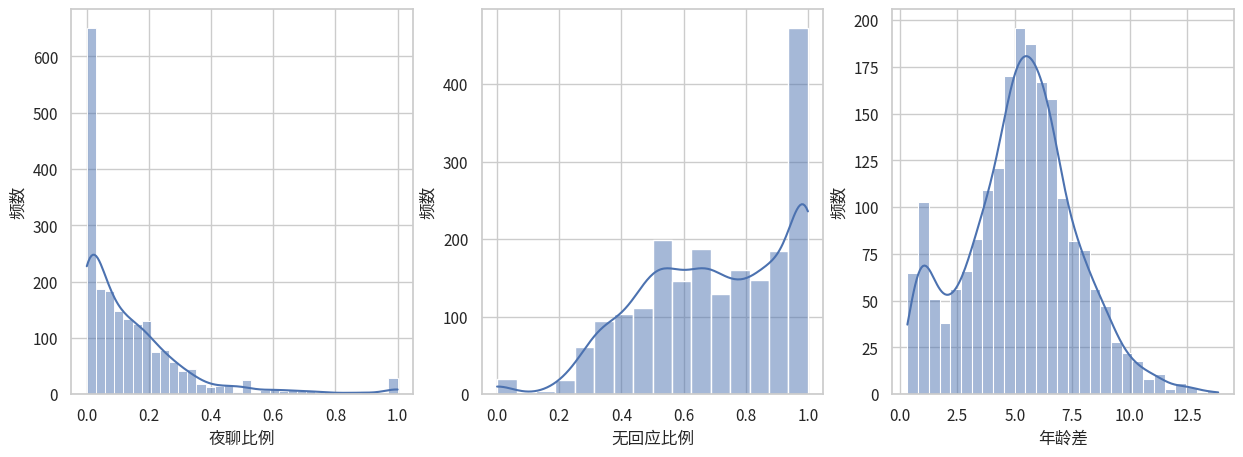

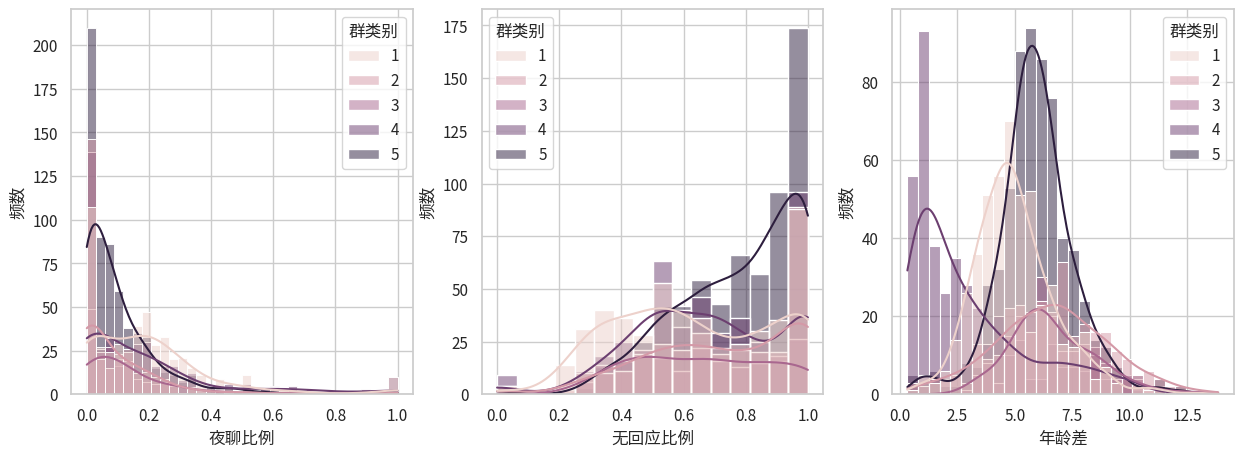

In [257]:
draw_hist(df, chosen_cols, hue_col='群类别')

### 正态性检验

我们使用 for 循环来对每个变量进行多种正态性检验方法。
注意ANOVA的正态性是说分组的正态性。
如果每一组都是正态分布，而且零假设不成立，那合在一起其实是Gaussian Mixture Model。

下面的代码我们引入log=False 参数，决定是对原始数据还是对log数据进行正态性检验。

In [ ]:
#| export
import numpy as np

In [ ]:
#| export
def test_normality_group(df, interesting_col, hue_col='群类别', transform = None):
    if transform is None:
        transform = lambda x: x
    grouped_data = df.groupby(hue_col)
    # grouped_data
    normality_results = {}
    for name, group in grouped_data:
        normality_result = {}
        data_column = group[interesting_col].to_numpy()
        data_column = transform(data_column)
        res = stats.ks_1samp(data_column, stats.norm.cdf, alternative='two-sided')
        normality_result['Kolmogorov-Smirnov'] = "Not Normal" if res.pvalue < 0.05 else "Normal"
        res = stats.anderson(data_column, dist='norm')
        critical_value = res.critical_values[2] # 0.05 level
        normality_result['Anderson-Darling'] = "Not Normal" if res.statistic > critical_value else "Normal"
        res = stats.normaltest(data_column)
        normality_result["D'Agostino-Pearson"] = "Not Normal" if res.pvalue < 0.05 else "Normal"
        normality_results[name] = normality_result
    return pd.DataFrame(normality_results)

In [195]:
for i, col in enumerate(chosen_cols):
    print(f"Testing normality for column {col}")
    print(test_normality_group(df, col))

Testing normality for column 夜聊比例
                             1           2           3           4           5
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Testing normality for column 无回应比例
                             1           2           3           4           5
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Testing normality for column 年龄差
                             1           2           3           4           5
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal      Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Norma

可以看到除了 年龄差的第二组以外，其他的数据根本不满足正态分布。

我们再尝试一下log后的正态性检验。

In [215]:
log_transform = lambda data_column: np.log(data_column+np.min(data_column)+1)  # 保证 大于0 
# np.log(data_column) 
log_transform([1,2,3,4,5])

array([1.09861229, 1.38629436, 1.60943791, 1.79175947, 1.94591015])

In [ ]:
for i, col in enumerate(chosen_cols):
    print(f"Testing normality for column log({col})")
    print(test_normality_group(df, col, transform=log_transform))

Testing normality for column log(夜聊比例)
                             1           2           3           4           5
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Testing normality for column log(无回应比例)
                             1           2           3           4           5
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Testing normality for column log(年龄差)
                             1           2           3           4           5
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal      Normal  Not Normal  Not Normal
D'Agostino-Pea

看来并没有什么特别效果，还是不正态的多，年龄差的第二组反而变得不正态了，第三组正态了。

#### 方差齐性检验
我们首先使用 Rule of thumb 经验法则 和 bartlett 检验一起来看

In [ ]:
#| export
from scipy import stats

In [ ]:
#| export
def homogeneity_of_variance(df, interesting_col, hue_col="群类别", transform=None):
    if transform is None:
        transform = lambda x: x
    new_col_name = f"{interesting_col}_transformed_tmp"
    df[new_col_name] = transform(df[interesting_col].to_numpy())
    interesting_col = new_col_name
    
    grouped_data = df.groupby(hue_col)

    std_devs = grouped_data[interesting_col].std()
    ratio_largest_to_smallest = std_devs.max() / std_devs.min() 
    variance_homogeneity = ratio_largest_to_smallest<= 2
    if not variance_homogeneity:
        print("The variances are not homogeneous!")
    else:
        print("The variances may be homogeneous, according to rule of thumb.")
    
    group_values_list = [grouped_data[interesting_col].get_group(x).values for x in grouped_data.groups]
    bartlett_result = stats.bartlett(*group_values_list)
    if bartlett_result.pvalue < 0.05:
        print("Reject the null hypothesis of equal variances! ")
        
    del df[new_col_name]

    return dict(
        ratio_largest_to_smallest=ratio_largest_to_smallest,
        bartlett_result=bartlett_result
    )

In [213]:
for i, chosen_col in enumerate(chosen_cols):
    print(f"Now testing variance_homogeneity of column: {chosen_col}")
    print(homogeneity_of_variance(df, chosen_col, transform=None))
    print()

Now testing variance_homogeneity of column: 夜聊比例
The variances may be homogeneous, according to rule of thumb.
Reject the null hypothesis of equal variances! 
{'ratio_largest_to_smallest': 1.7654023254103777, 'bartlett_result': BartlettResult(statistic=184.4526258346371, pvalue=8.244412669557808e-39)}

Now testing variance_homogeneity of column: 无回应比例
The variances may be homogeneous, according to rule of thumb.
Reject the null hypothesis of equal variances! 
{'ratio_largest_to_smallest': 1.2996307493612391, 'bartlett_result': BartlettResult(statistic=44.64819549378769, pvalue=4.705138240554607e-09)}

Now testing variance_homogeneity of column: 年龄差
The variances may be homogeneous, according to rule of thumb.
Reject the null hypothesis of equal variances! 
{'ratio_largest_to_smallest': 1.5888982653697075, 'bartlett_result': BartlettResult(statistic=155.50950582298964, pvalue=1.342198169091211e-32)}



In [216]:
for i, chosen_col in enumerate(chosen_cols):
    print(f"Now testing variance_homogeneity of column: log({chosen_col})")
    print(homogeneity_of_variance(df, chosen_col, transform=log_transform))
    print()

Now testing variance_homogeneity of column: log(夜聊比例)
The variances may be homogeneous, according to rule of thumb.
Reject the null hypothesis of equal variances! 
{'ratio_largest_to_smallest': 1.6365600965654272, 'bartlett_result': BartlettResult(statistic=139.12782583219428, pvalue=4.338695149250475e-29)}

Now testing variance_homogeneity of column: log(无回应比例)
The variances may be homogeneous, according to rule of thumb.
Reject the null hypothesis of equal variances! 
{'ratio_largest_to_smallest': 1.3586915605576353, 'bartlett_result': BartlettResult(statistic=61.67293119869295, pvalue=1.2906782641394537e-12)}

Now testing variance_homogeneity of column: log(年龄差)
The variances are not homogeneous!
Reject the null hypothesis of equal variances! 
{'ratio_largest_to_smallest': 2.282065192732663, 'bartlett_result': BartlettResult(statistic=386.6067271555664, pvalue=2.17718926130104e-82)}



进行log之后反而年龄差连拇指法则都认为不满足方差齐性了，太可怕了。看来log变换对这三列数据不太有效果。

## 5. How to do one-way ANOVA with the non-normal data?

### 5.a Find and list the possible solutions set.

经过查找网络资料，我们采纳[论文4.2.1节](https://ri.conicet.gov.ar/bitstream/handle/11336/31210/CONICET_Digital_Nro.dd9c5c0f-c69e-4018-9d9c-cb111fec6c77_A.pdf;jsessionid=E7832F681CB808FDC759C8152D13EE89?sequence=2)的总结方式，当数据不满足服从正态分布时，有三类解决思路，数据转换、非参数检验和广义线性模型。

1. 通过数据转换，把原本数据转换为服从正态分布的数据，比如log变换、Box-Cox变换等，然后我们对转换后的数据进行ANOVA分析。
- 有哪些变换？log变换、Box-Cox变换、平方根转换和反正弦平方根转换等。
- 缺点：[论文4.2.2节](https://ri.conicet.gov.ar/bitstream/handle/11336/31210/CONICET_Digital_Nro.dd9c5c0f-c69e-4018-9d9c-cb111fec6c77_A.pdf;jsessionid=E7832F681CB808FDC759C8152D13EE89?sequence=2)指出，转换可能会改变原始数据的解释，且需要谨慎选择合适的转换方法以确保分析结果的准确性。
2. 换一个不需要假设正态分布的、功能类似的检验方法（一般是非参数检验方法），比如Kruskal-Wallis检验。
- 优点：
    - 非参数检验不需要数据服从正态分布，因此在数据不满足正态性假设时仍能提供有效的结果。
    - 这个不局限于正态假设不满足，其他ANOVA假设不满足也可以用。比如[文章](https://onlinepubs.trb.org/onlinepubs/nchrp/cd-22/manual/v2chapter4.pdf)指出，如果方差齐性假设不满足，要用Kruskal-Wallis检验。
    - [机器学习经典的一篇万引论文](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf)指出，多个数据集上对比不同的机器学习方法不应当使用ANOVA，因为正态性假设和方差齐性假设不一定成立，所以应当使用Friedman检验。
- 缺点：非参数检验通常比参数检验具有较低的统计功效，这意味着在相同条件下更容易犯第二类错误（即未能拒绝错误的零假设）
3. 上文我们提到，ANOVA和线性回归的参数非零检验是有等价的，而线性回归的误差项被假设为是正态分布，所以才导致ANOVA需要假设正态分布，所以我们可以使用广义线性模型（误差项可以服从泊松分布、二项分布等），然后进行分析。
- 可以参考[这本书第十讲](https://bookdown.org/hetongqi0320/qht_R4psyBook/%E7%AC%AC%E5%8D%81%E8%AE%B2%E5%9B%9E%E5%BD%92%E6%A8%A1%E5%9E%8B%E4%B8%89%E5%B9%BF%E4%B9%89%E7%BA%BF%E6%80%A7%E6%A8%A1%E5%9E%8B.html)



### 5.b Do the one-way ANOVA on the 3 columns you choose. Do these feature columns vary significantly? Visualize the results.

刚才在 4. 中我们发现，简单使用log变换仍然无法让数据满足正态分布，甚至会破坏方差齐性！我们得尝试使用 5.a中的办法来改进一下！

#### 直接进行 ANOVA 分析

刚才我们注意到，log变换之前其实数据已经满足拇指法则的要求，方差齐性问题不大；而正态性假设不满足我们勉强接受，开始直接进行 ANOVA 分析。

调用我们刚才自己编写的 `anova_oneway` 函数，这里我们实现 `auto_anova_for_df` 提高API的易用性。


In [227]:
#| export 
def auto_anova_for_df(df, interesting_col, hue_col="群类别", transform=None):
    if transform is None:
        transform = lambda x: x
    new_col_name = f"{interesting_col}_transformed_tmp"
    df[new_col_name] = transform(df[interesting_col].to_numpy())
    interesting_col = new_col_name
    grouped_data = df.groupby(hue_col)
    group_values_list = [grouped_data[interesting_col].get_group(x).values for x in grouped_data.groups]
    res = anova_oneway(*group_values_list)
    del df[new_col_name]
    return res

In [237]:
res_dfs = []
for chosen_col in chosen_cols:
    # print(f"Doing ANOVA for {chosen_col}")
    # print()
    res = auto_anova_for_df(df, chosen_col)
    res_dfs.append(res)
    
# index = pd.MultiIndex.from_tuples([(x, y) for x in chosen_cols for y in ["Between", "Within", "Total"]],
#                             names=['Category', 'Source'])
# df_combined = pd.DataFrame(index=index, columns=res_dfs[0].columns)
# for i, source in enumerate(chosen_cols):
#     # for s in ['Between', 'Within', 'Total']:
#     #         df_combined.loc[(source, s)] = res_dfs[i].loc[res_dfs[i]['Source'] == s, :]
#     df_combined.iloc[i] = res_dfs[i].values
# df_combined
print(chosen_cols[0])
res_dfs[0]

夜聊比例


,Source,Sum of Squares (SS),Degrees of Freedom (df),Mean Square (MS),F,p,p_excel
0,Between,3.721528,4,0.930382,28.077748,1.110223e-16,1.842338e-22
1,Within,67.431602,2035,0.033136,NaN,NaN,NaN
2,Total,71.153130,2039,NaN,NaN,NaN,NaN


In [238]:
print(chosen_cols[1])
res_dfs[1]

无回应比例


,Source,Sum of Squares (SS),Degrees of Freedom (df),Mean Square (MS),F,p,p_excel
0,Between,6.689130,4,1.672283,31.788299,1.110223e-16,1.859627e-25
1,Within,107.054963,2035,0.052607,NaN,NaN,NaN
2,Total,113.744093,2039,NaN,NaN,NaN,NaN


In [239]:
print(chosen_cols[2])
res_dfs[2]

年龄差


,Source,Sum of Squares (SS),Degrees of Freedom (df),Mean Square (MS),F,p,p_excel
0,Between,3338.236332,4,834.559083,200.242216,1.110223e-16,9.043259e-145
1,Within,8481.367055,2035,4.167748,NaN,NaN,NaN
2,Total,11819.603387,2039,NaN,NaN,NaN,NaN


看来这三个特征还是很明显会被群类别影响的！p值非常小！
接下来可视化！

In [247]:
#| export
def draw_box(df, chosen_cols, hue_col='群类别', transform = None, column_name_transform = None):
    if transform is None: transform = lambda x: x
    if column_name_transform is None: column_name_transform = lambda x: x
    fig, axs = plt.subplots(1, len(chosen_cols), figsize=(15, 5))  #
    for i, col in enumerate(chosen_cols):
        df[f"{col}_transformed_tmp"] = transform(df[col].to_numpy())
        sns.boxplot(x=hue_col, y=f"{col}_transformed_tmp", data=df, ax=axs[i])
        axs[i].set_ylabel(column_name_transform(col))
        del df[f"{col}_transformed_tmp"]

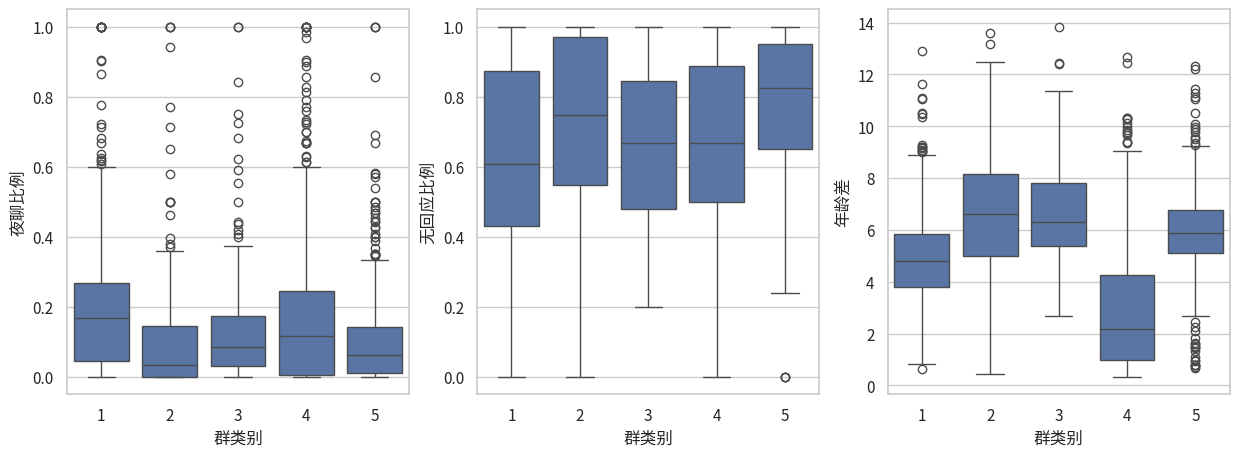

In [248]:
draw_box(df, chosen_cols)

#### 应用解决办法2——采用不对数据要求那么严格的假设检验方法


##### Friedman检验

[机器学习经典的一篇万引论文](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf)指出，多个数据集上对比不同的机器学习方法不应当使用ANOVA，因为正态性假设和方差齐性假设不一定成立，所以应当使用Friedman检验。

这里我们采用Friedman检验尝试一下，看看是否如这篇论文说的那么适合。

使用 scipy实现的 `friedmanchisquare`

In [ ]:
#| export 
from scipy import stats

In [ ]:
#| export 
def auto_friedman_for_df(df, interesting_col, hue_col="群类别", transform=None):
    if transform is None:
        transform = lambda x: x
    new_col_name = f"{interesting_col}_transformed_tmp"
    df[new_col_name] = transform(df[interesting_col].to_numpy())
    interesting_col = new_col_name
    grouped_data = df.groupby(hue_col)
    group_values_list = [grouped_data[interesting_col].get_group(x).values for x in grouped_data.groups]
    
    res = stats.friedmanchisquare(*group_values_list)
    
    del df[new_col_name]
    return res

In [261]:
res_dfs = []
try:
    for chosen_col in chosen_cols:
        # print(f"Doing ANOVA for {chosen_col}")
        # print()
        res = auto_friedman_for_df(df, chosen_col)
        res_dfs.append(res)
    print(f"Friedman for col {chosen_cols[0]}")
except Exception as e:
    print(f"Error: {e}")

Error: Unequal N in friedmanchisquare.  Aborting.


实践出真知，原来 Friedman 测试要求每个treatment有相同的数据量！这确实适合对比机器学习方法，因为这些方法都在N个数据集上做了实验，但是确实不适合我们这里的数据。

##### Kruskal-Wallis

再来尝试一下 [这个](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

In [ ]:
#| export 
from scipy import stats

In [ ]:
#| export 
def auto_kruskal_for_df(df, interesting_col, hue_col="群类别", transform=None):
    if transform is None:
        transform = lambda x: x
    new_col_name = f"{interesting_col}_transformed_tmp"
    df[new_col_name] = transform(df[interesting_col].to_numpy())
    interesting_col = new_col_name
    grouped_data = df.groupby(hue_col)
    group_values_list = [grouped_data[interesting_col].get_group(x).values for x in grouped_data.groups]
    
    res = stats.kruskal(*group_values_list)
    
    del df[new_col_name]
    return res

In [266]:
res_dfs = []
for chosen_col in chosen_cols:
    # print(f"Doing ANOVA for {chosen_col}")
    # print()
    res = auto_kruskal_for_df(df, chosen_col)
    res_dfs.append(res)
k = 0
print(f"Kruskal-Wallis for col {chosen_cols[k]}")
res_dfs[k]

Kruskal-Wallis for col 夜聊比例


KruskalResult(statistic=113.85430517053221, pvalue=1.0958066785877727e-23)

In [267]:
k = 1
print(f"Kruskal-Wallis for col {chosen_cols[k]}")
res_dfs[k]

Kruskal-Wallis for col 无回应比例


KruskalResult(statistic=110.47802046935365, pvalue=5.754933877750579e-23)

In [268]:
k = 2
print(f"Kruskal-Wallis for col {chosen_cols[k]}")
res_dfs[k]

Kruskal-Wallis for col 年龄差


KruskalResult(statistic=550.9540936771726, pvalue=6.360595079827829e-118)

Kruskal-Wallis H-test tests的零假设是 不同组的中位数之间没有显著差异。
看来我们对于我们选中的三列，p值都特别小，说明我们可以拒绝零假设，认为这三列都会被“群类型”影响，导致中位数不相同。

In [269]:
#| hide
import nbdev; nbdev.nbdev_export()